In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sys
from platform import python_version

In [2]:
print(torch.__version__)

1.6.0


In [3]:
print(python_version())

3.8.5


# 2.1 Introduction to Autograd

## What is Autograd

Autograd package is an engine to calculate derivatives which is Jacobian-vector product. It provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

## Why Autograd

Neural networks are nothing more than composite mathematical functions that are delicately tweaked (trained) to output the required result. The tweaking or the training is done through a remarkable algorithm called backpropagation. Backpropagation is used to calculate the gradients of the loss with respect to the input weights to later update the weights and eventually reduce the loss. With autograd, we can skip all the steps to manually calculate our gradients. This can save us time and energy.

## How to perform Autograd

In [4]:
# without autograd
t_1 = torch.randn(5)
print(f'Without autograd: {t_1}')

# with autograd
t_2 = torch.randn(5, requires_grad=True)
print(f'With autograd: {t_2}')

Without autograd: tensor([ 1.2522,  0.7074,  0.4892, -1.2172, -1.0610])
With autograd: tensor([-0.3159,  2.5039,  0.0622, -0.4719, -0.0638], requires_grad=True)


In [5]:
t_add = t_1 + t_2
print(f'Addition of tensor: {t_add}')
print(f'Addition of tensor with autograd has attribute of requires_grad: {t_add.requires_grad}')

Addition of tensor: tensor([ 0.9363,  3.2114,  0.5514, -1.6891, -1.1248], grad_fn=<AddBackward0>)
Addition of tensor with autograd has attribute of requires_grad: True


In this case, grad_fn has attribute of `AddBackward` because our tensor operation is addition.

In [6]:
t_sub = t_1 - t_2
t_mul = t_1 * t_2
t_mean = t_add.mean()
t_sig = t_add.sigmoid()
print(f'Subtraction of tensor with autograd has attribute of requires_grad: {t_sub.requires_grad}')
print(f'Multiplication of tensor with autograd has attribute of requires_grad: {t_mul.requires_grad}')
print(f'Mean of tensor with autograd has attribute of requires_grad: {t_mean.requires_grad}')
print(f'Sigmoid of tensor with autograd has attribute of requires_grad: {t_sig.requires_grad}')

Subtraction of tensor with autograd has attribute of requires_grad: True
Multiplication of tensor with autograd has attribute of requires_grad: True
Mean of tensor with autograd has attribute of requires_grad: True
Sigmoid of tensor with autograd has attribute of requires_grad: True


## How grad is stored in tensor

Gradient(s) are calculated automatically by calling `.backward()` function.

In [7]:
t_mean.backward()

In [8]:
print(f'Gradient of t_1 without autograd: {t_1.grad}')
print(f'Gradient of t_2 with autograd: {t_2.grad}')

Gradient of t_1 without autograd: None
Gradient of t_2 with autograd: tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


> grad can be implicitly created only for **_scalar_** outputs.

Basically need to multiply with vector to produce scalar output, which is Jacobian product.

## How to exclude gradient calculation

Sometimes during our training loop when we want to update our weights, then this operation should not be part of the gradient computation. Therefore, we need to exclude gradient calculation. We can do it with 3 ways:
- `x.requires_grad_(False)`
- `x.detach()`
- `with torch.no_grad():`

In [9]:
t_1 = torch.randn(5, requires_grad=True)
print(f'Autograd tensor: {t_1}')

t_1.requires_grad_(False)
print(f'Without autograd tensor: {t_1}')

Autograd tensor: tensor([-0.0768,  2.4343, -0.5166,  1.1302, -0.2102], requires_grad=True)
Without autograd tensor: tensor([-0.0768,  2.4343, -0.5166,  1.1302, -0.2102])


In [10]:
# detach() will create new tensor with same value but it doesn't require the gradient

t_2 = t_1.detach()
print(f't_2: {t_2}')

t_2: tensor([-0.0768,  2.4343, -0.5166,  1.1302, -0.2102])


In [11]:
t_1 = torch.randn(5, requires_grad=True)
print(f'Autograd tensor: {t_1}')

t_1.detach_()
print(f'Inplace detach tensor: {t_1}')

Autograd tensor: tensor([-0.8400,  1.0018,  0.1635,  0.5059, -0.9668], requires_grad=True)
Inplace detach tensor: tensor([-0.8400,  1.0018,  0.1635,  0.5059, -0.9668])


In [12]:
t_1 = torch.randn(5, requires_grad=True)
print(f't_1: {t_1}')

t_ans = t_1 + 2
print(f't_ans: {t_ans}')

with torch.no_grad():
    t_ans = t_1 + 2
    print(f't_ans: {t_ans}')
print(f'Final t_ans: {t_ans}')

t_1: tensor([-0.2213,  1.3219,  0.1917,  0.0113, -0.9784], requires_grad=True)
t_ans: tensor([1.7787, 3.3219, 2.1917, 2.0113, 1.0216], grad_fn=<AddBackward0>)
t_ans: tensor([1.7787, 3.3219, 2.1917, 2.0113, 1.0216])
Final t_ans: tensor([1.7787, 3.3219, 2.1917, 2.0113, 1.0216])


Note that whenever we call `.backward()`, the gradient for this tensor will be accumulated in `.grad` attribute. As the result their values will be summed up.

In [13]:
weights = torch.tensor([1., 2., 3., 4., 5.], requires_grad=True)
for epoch in range(5):
    output = (weights*2).sum()
    output.backward()
    print(f'Epoch {epoch}: {weights.grad}')

Epoch 0: tensor([2., 2., 2., 2., 2.])
Epoch 1: tensor([4., 4., 4., 4., 4.])
Epoch 2: tensor([6., 6., 6., 6., 6.])
Epoch 3: tensor([8., 8., 8., 8., 8.])
Epoch 4: tensor([10., 10., 10., 10., 10.])


All the gradients are summed up and our weights or gradients are clearly incorrect. Before we do the next iteration step and optimization step, we must empty the gradient so we must call `.grad.zero_()` function.

In [14]:
weights = torch.tensor([1., 2., 3., 4., 5.], requires_grad=True)
for epoch in range(5):
    output = (weights*2).sum()
    output.backward()
    print(f'Epoch {epoch}: {weights.grad}')
    weights.grad.zero_()

Epoch 0: tensor([2., 2., 2., 2., 2.])
Epoch 1: tensor([2., 2., 2., 2., 2.])
Epoch 2: tensor([2., 2., 2., 2., 2.])
Epoch 3: tensor([2., 2., 2., 2., 2.])
Epoch 4: tensor([2., 2., 2., 2., 2.])


# 2.2 Linear Regression Example

General linear regression function: $$y = wX + b$$

In this example, let our function $f(x) = 4x$, for now just ignore bias b. First we will generate dummy data of X and Y. Below is the plot of our data which the function $f(x) = 4x$. We will use linear regression to find the weight/gradient which should be **w = 4** and predict the y value respective to x value of 250 which should be **y = 1000**

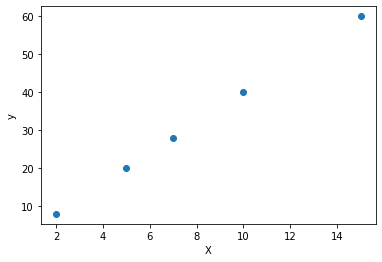

In [15]:
X = np.array([2, 5, 7, 10, 15], dtype=np.float32)
y = np.array([8, 20, 28, 40, 60], dtype=np.float32)
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

There are many ways to do linear regression. Here we will show you 3 ways to do so which are:
- Linear Regression using **NumPy** 
- Linear Regression using **PyTorch** without **_Autograd_**
- Linear Regression using **PyTorch** with **_Autograd_**

## Linear Regression using NumPy

First, lets initiate weight to zero and some of our hyperparameters at the beginning. 

In [16]:
w = 0.0
learning_rate = 0.001
n_iters = 15

Define `forward()` function to return model prediction.

In [17]:
def forward(x):
    return w * x

Define `lossMSE()` for our loss function. In this case, we will use **Mean Square Error** for our loss function.
$$MSE = \frac {1}{N}(Y\_Pred- Y)^2$$

In [18]:
def lossMSE(y, y_pred):
    return ((y_pred - y)**2).mean()

Define `gradient()` function to return gradient of the loss with respect to our parameters.
$$\frac{dJ}{dw} = \frac{1}{N}(2X)(Y\_Pred-Y)$$

In [19]:
def gradient(x, y, y_pred):
    return np.dot(2*x, y_pred-y).mean()

Then we first make use the linear regression to predict $f(250)$ before the training.

In [20]:
print(f'Prediction before training: f(250) = {forward(250):.3f}')

Prediction before training: f(250) = 0.000


Now we will train our linear regression model.

In [21]:
for epoch in range(n_iters):
    # forward pass
    y_pred = forward(X)
    
    # loss
    loss = lossMSE(y, y_pred)
    
    # backward pass
    dw = gradient(X, y, y_pred)
    
    # update weights
    w -= learning_rate * dw
    
    print(f'Epoch {epoch+1}: weight = {w:.5f}, loss = {loss:.10f}')

Epoch 1: weight = 3.22400, loss = 1289.5999755859
Epoch 2: weight = 3.84946, loss = 48.5353889465
Epoch 3: weight = 3.97079, loss = 1.8266773224
Epoch 4: weight = 3.99433, loss = 0.0687492341
Epoch 5: weight = 3.99890, loss = 0.0025873384
Epoch 6: weight = 3.99979, loss = 0.0000973676
Epoch 7: weight = 3.99996, loss = 0.0000036680
Epoch 8: weight = 3.99999, loss = 0.0000001368
Epoch 9: weight = 4.00000, loss = 0.0000000053
Epoch 10: weight = 4.00000, loss = 0.0000000002
Epoch 11: weight = 4.00000, loss = 0.0000000000
Epoch 12: weight = 4.00000, loss = 0.0000000000
Epoch 13: weight = 4.00000, loss = 0.0000000000
Epoch 14: weight = 4.00000, loss = 0.0000000000
Epoch 15: weight = 4.00000, loss = 0.0000000000


In [22]:
print(f'Prediction after training: f(250) = {forward(250):.3f}')

Prediction after training: f(250) = 1000.000


## Linear Regression using PyTorch without Autograd

Now we will use PyTorch to train our linear regression model. First, we convert our dataset X, Y from numpy array to pytorch tensor using `torch.from_numpy()` and initiate tensor w with zero using `torch.tensor()`.

In [23]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)
w = torch.zeros(1, dtype=torch.float32)

Then we define some functions for our linear regression.

In [24]:
def forward(x):
    return w * x
def lossMSE(y, y_pred):
    return ((y_pred - y)**2).mean()
def gradient(x, y, y_pred):
    return torch.matmul(2*x, y_pred-y).mean()

Then we define our linear regression function without autograd.

In [25]:
def linearRegressionNoAutograd(x, y, w):
    print(f'Prediction before training: f(250) = {forward(250).item():.3f}')
    for epoch in range(n_iters):
        y_pred = forward(X)
        loss = lossMSE(y, y_pred)
        dw = gradient(X, y, y_pred)
        w -= learning_rate * dw
        print(f'Epoch {epoch+1}: weight = {w.item():.5f}, loss = {loss.item():.10f}')
    print(f'Prediction after training: f(250) = {forward(250).item():.3f}')

In [26]:
linearRegressionNoAutograd(X, y, w)

Prediction before training: f(250) = 0.000
Epoch 1: weight = 3.22400, loss = 1289.5999755859
Epoch 2: weight = 3.84946, loss = 48.5353584290
Epoch 3: weight = 3.97079, loss = 1.8266773224
Epoch 4: weight = 3.99433, loss = 0.0687492341
Epoch 5: weight = 3.99890, loss = 0.0025873384
Epoch 6: weight = 3.99979, loss = 0.0000973676
Epoch 7: weight = 3.99996, loss = 0.0000036619
Epoch 8: weight = 3.99999, loss = 0.0000001368
Epoch 9: weight = 4.00000, loss = 0.0000000053
Epoch 10: weight = 4.00000, loss = 0.0000000002
Epoch 11: weight = 4.00000, loss = 0.0000000000
Epoch 12: weight = 4.00000, loss = 0.0000000000
Epoch 13: weight = 4.00000, loss = 0.0000000000
Epoch 14: weight = 4.00000, loss = 0.0000000000
Epoch 15: weight = 4.00000, loss = 0.0000000000
Prediction after training: f(250) = 1000.000


## Linear Regression using PyTorch with Autograd

With `autograd`, we no need to manually calculate gradient anymore with `.backward()` function.

In [27]:
w.zero_()
w.requires_grad_(True)

tensor([0.], requires_grad=True)

Then we define our linear regression function with autograd.

In [28]:
def linearRegressionAutograd(X, y, w):
    print(f'Prediction before training: f(250) = {forward(250).item():.3f}')
    for epoch in range(n_iters):
        y_pred = forward(X)
        loss = lossMSE(y, y_pred)
        loss.backward()
        with torch.no_grad():
            w -= learning_rate * w.grad
        w.grad.zero_()
        print(f'Epoch {epoch+1}: weight = {w.item():.5f}, loss = {loss.item():.10f}')
    print(f'Prediction after training: f(250) = {forward(250).item():.3f}')

In [29]:
linearRegressionAutograd(X, y, w)

Prediction before training: f(250) = 0.000
Epoch 1: weight = 0.64480, loss = 1289.5999755859
Epoch 2: weight = 1.18566, loss = 907.3437500000
Epoch 3: weight = 1.63933, loss = 638.3938598633
Epoch 4: weight = 2.01987, loss = 449.1645507812
Epoch 5: weight = 2.33907, loss = 316.0256347656
Epoch 6: weight = 2.60681, loss = 222.3510284424
Epoch 7: weight = 2.83139, loss = 156.4429626465
Epoch 8: weight = 3.01977, loss = 110.0709838867
Epoch 9: weight = 3.17778, loss = 77.4443664551
Epoch 10: weight = 3.31033, loss = 54.4887313843
Epoch 11: weight = 3.42150, loss = 38.3374862671
Epoch 12: weight = 3.51476, loss = 26.9736938477
Epoch 13: weight = 3.59298, loss = 18.9782981873
Epoch 14: weight = 3.65859, loss = 13.3528470993
Epoch 15: weight = 3.71362, loss = 9.3948707581
Prediction after training: f(250) = 928.406


`.backward()` back propagation function is not as exact as numerical gradient computation. So we may requires to tune our hyperparameters such as number of iterations and learning rates. Lets reset our weight to zero using `.storage()`. Note that we can't reset our w using inplace operation.
> PyTorch doesn’t allow in-place operations on leaf variables that have requires_grad=True (such as parameters of your model) because the developers could not decide how such an operation should behave. If you want the operation to be differentiable, you can work around the limitation by cloning the leaf variable (or use a non-inplace version of the operator). Source: [PyTorch Forum](https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/2)

In [30]:
learning_rate = 0.005
w.storage()[:] = 0
linearRegressionAutograd(X, y, w)

Prediction before training: f(250) = 0.000
Epoch 1: weight = 3.22400, loss = 1289.5999755859
Epoch 2: weight = 3.84946, loss = 48.5353889465
Epoch 3: weight = 3.97079, loss = 1.8266817331
Epoch 4: weight = 3.99433, loss = 0.0687492341
Epoch 5: weight = 3.99890, loss = 0.0025873384
Epoch 6: weight = 3.99979, loss = 0.0000973676
Epoch 7: weight = 3.99996, loss = 0.0000036619
Epoch 8: weight = 3.99999, loss = 0.0000001368
Epoch 9: weight = 4.00000, loss = 0.0000000053
Epoch 10: weight = 4.00000, loss = 0.0000000002
Epoch 11: weight = 4.00000, loss = 0.0000000000
Epoch 12: weight = 4.00000, loss = 0.0000000000
Epoch 13: weight = 4.00000, loss = 0.0000000000
Epoch 14: weight = 4.00000, loss = 0.0000000000
Epoch 15: weight = 4.00000, loss = 0.0000000000
Prediction after training: f(250) = 1000.000


### Introduction to Optimizer and Loss Function

**Optimizers** are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Optimizers are used to solve optimization problems by minimizing the function. [Source](https://towardsdatascience.com/overview-of-various-optimizers-in-neural-networks-17c1be2df6d5)

**Loss function** is a method of evaluating how well specific algorithm models the given data. If predictions deviates too much from actual results, loss function would cough up a very large number. Gradually, with the help of some optimization function, loss function learns to reduce the error in prediction. [Source](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23)

In [31]:
optimizer = torch.optim.SGD([w], lr=learning_rate)
lossMSE = nn.MSELoss()

In [32]:
def linearRegressionAutogradOptimizerLoss(X, y, w):
    print(f'Prediction before training: f(250) = {forward(250).item():.3f}')
    for epoch in range(n_iters):
        y_pred = forward(X)
        loss = lossMSE(y, y_pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'Epoch {epoch+1}: weight = {w.item():.5f}, loss = {loss.item():.10f}')
    print(f'Prediction after training: f(250) = {forward(250).item():.3f}')

In [33]:
w.storage()[:] = 0
linearRegressionAutogradOptimizerLoss(X, y, w)

Prediction before training: f(250) = 0.000
Epoch 1: weight = 3.22400, loss = 1289.5999755859
Epoch 2: weight = 3.84946, loss = 48.5353889465
Epoch 3: weight = 3.97079, loss = 1.8266817331
Epoch 4: weight = 3.99433, loss = 0.0687492341
Epoch 5: weight = 3.99890, loss = 0.0025873384
Epoch 6: weight = 3.99979, loss = 0.0000973676
Epoch 7: weight = 3.99996, loss = 0.0000036619
Epoch 8: weight = 3.99999, loss = 0.0000001368
Epoch 9: weight = 4.00000, loss = 0.0000000053
Epoch 10: weight = 4.00000, loss = 0.0000000002
Epoch 11: weight = 4.00000, loss = 0.0000000000
Epoch 12: weight = 4.00000, loss = 0.0000000000
Epoch 13: weight = 4.00000, loss = 0.0000000000
Epoch 14: weight = 4.00000, loss = 0.0000000000
Epoch 15: weight = 4.00000, loss = 0.0000000000
Prediction after training: f(250) = 1000.000


# Exercise

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

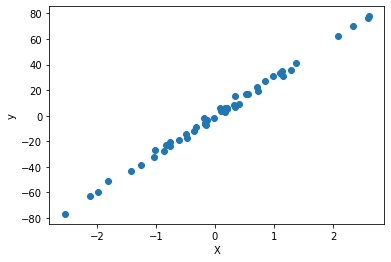

In [35]:
X, y = make_regression(n_samples=50, n_features=1, noise=2, random_state=428)
X = torch.from_numpy(X).reshape(50, 1)
y = torch.from_numpy(y).reshape(50, 1)
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [36]:
print(f'Size of X: {X.shape}')
print(f'Size of y: {y.shape}')

Size of X: torch.Size([50, 1])
Size of y: torch.Size([50, 1])


**_TASK_**: Build a **linear regression model** to predict the y value of 428 using **PyTorch** with autograd, optimizer and loss function.
> **Challenge**: Convergence of model within 15 iterations.

In [37]:
w = torch.zeros(1, dtype=torch.float32, requires_grad=True)
learning_rate = 0.5
n_iters = 15
optimizer = torch.optim.SGD([w], lr=learning_rate)
lossMSE = nn.MSELoss()
def forward(x):
    return w * x
print(f'Prediction before training: f(428) = {forward(428).item():.3f}')
for epoch in range(n_iters):
    y_pred = forward(X)
    loss = lossMSE(y, y_pred)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f'Epoch {epoch+1}: weight = {w.item():.5f}, loss = {loss.item():.10f}')
print(f'Prediction after training: f(428) = {forward(428).item():.3f}')

Prediction before training: f(428) = 0.000
Epoch 1: weight = 37.05470, loss = 1109.0525983911
Epoch 2: weight = 28.08921, loss = 68.2152182504
Epoch 3: weight = 30.25844, loss = 7.2834470082
Epoch 4: weight = 29.73359, loss = 3.7164326422
Epoch 5: weight = 29.86058, loss = 3.5076151240
Epoch 6: weight = 29.82985, loss = 3.4953909304
Epoch 7: weight = 29.83729, loss = 3.4946753395
Epoch 8: weight = 29.83549, loss = 3.4946334364
Epoch 9: weight = 29.83592, loss = 3.4946309833
Epoch 10: weight = 29.83582, loss = 3.4946308398
Epoch 11: weight = 29.83584, loss = 3.4946308314
Epoch 12: weight = 29.83584, loss = 3.4946308310
Epoch 13: weight = 29.83584, loss = 3.4946308309
Epoch 14: weight = 29.83584, loss = 3.4946308309
Epoch 15: weight = 29.83584, loss = 3.4946308309
Prediction after training: f(428) = 12769.739


**Expected Output:**
```
weight = 29.835, loss = 3.494
Prediction after training: f(428) = 12769.(approx)
```